## Modeling Continuous Single Facility Location Problem with L1-norm Objective 

We are expected to model a continuous single facility location problem 
with L1-norm objective and program the problems in a computer environment. The goal is to 
determine the coordinates of the facility while minimizing the total distance to the customers. There are two approaches on how to linearize 
the model L1-norm objective function. The three methods that are to be implemented are specified 
in the following tasks.


In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from pulp import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Helper functions

# reads the text file and creates a dataframe
def data_frame_converter(path):
    with open(path, 'r') as file:
        lines = file.readlines()

    x_coordinates = []
    y_coordinates = []

    for line in lines:
        x, y = map(float, line.strip().split(','))
        x_coordinates.append(x)
        y_coordinates.append(y) 
    
    return pd.DataFrame({'X': x_coordinates, 'Y': y_coordinates})

# Displays the optimal value, optimal location and the graph
def summary(task, data):
    
    # extract data from the list
    optimal_value = task[1]
    x_value = task[2]
    y_value = task[3]
    
    coordinates = data.to_numpy()
    
    print("Optimal objective function value = ", optimal_value)
    print("Optimal location =", (x_value, y_value))

    plt.scatter(x=coordinates[:,0], y=coordinates[:,1], s=1)
    plt.scatter(x_value, y_value, s=10)
    plt.show()

# Task 1

$$
\text{Model}
$$

$$
\min \sum_{i} | x - x_i | + | y - y_i |
$$

$$
s.t.
$$

$$
x, y  \text{ free}
$$

In [2]:
# the function helps us build and solve the problem
def cvxpy_model_builder(data):
    
    # converts data frame to numpy array 
    coordinates = data.to_numpy()
    
    # number of customers is equal to half the size of the numpy array
    n = int(coordinates.size / 2)
    
   # facility location (x, y)
    x = cp.Variable(1) 
    y = cp.Variable(1) 
    
    # Distance from the center point to each (xi, yi)
    distances = cp.Variable(n) 
    
    # Adds the objective function
    objective_list = []

    for i in range(n):
        objective_list.append( cp.norm(x - coordinates[i][0], p=1))
    for i in range(n):
        objective_list.append( cp.norm(y - coordinates[i][1], p=1)) 

    
    # sets the objective
    objective = cp.Minimize(cp.sum(objective_list))
    problem = cp.Problem(objective)
    optimal_value = problem.solve()
    
    x_value = x.value[0]
    y_value = y.value[0]
    
    # returns the problem, optimal value of the problem and the optimal location of hte facility
    return [problem, optimal_value, x_value, y_value]

# Task 2

$$
\text{Model}
$$

$$
\text{min} \sum_{i} (a_i + b_i)
$$
$$
s.t.
$$
$$
-a_i \leq x - x_i \leq a_i
$$
$$
-b_i \leq y-y_i \leq b_i 
$$

$$
a_i, b_i \geq 0
$$

$$
\text{Python variables corresponding to model variables:}
$$

$$
\text{x_coordinates : }x_i
$$

$$
\text{y_coordinates : }y_i
$$

$$
\text{variables_ai : }a_i
$$

$$
\text{variables_bi : }b_i
$$

$$
x : x
$$

$$
y : y
$$

In [3]:
def pulp_model_builder_lecture(data):
    
    # Converting dataframe to dictionaries for x and y coordinates
    x_coordinates = data.to_dict()['X']
    y_coordinates = data.to_dict()['Y']
    
    # defines the model as a minimization problem
    model = LpProblem("Manhattan-Distance", LpMinimize)
    
    # creates the variables for the facility location, which are free variables
    x = LpVariable('x-facility', lowBound=None, upBound=None)
    y = LpVariable('y-facility', lowBound=None, upBound=None)
    
    # creats variables
    variables_ai  = LpVariable.dicts("a", x_coordinates.keys(), 0)
    variables_bi = LpVariable.dicts("b", x_coordinates.keys(), 0)
    
    # adds the onjective function to the model
    a = lpSum([variables_ai[i] for i in x_coordinates.keys()])
    b = lpSum([variables_bi[i] for i in x_coordinates.keys()])

    model += a + b
    
    # Adds constraints to the model
    for i in x_coordinates.keys():
        model += x - x_coordinates[i] <= variables_ai[i]
        model += x - x_coordinates[i] >= -variables_ai[i]
        model += y - y_coordinates[i] <= variables_bi[i]
        model += y - y_coordinates[i] >= -variables_bi[i] 
    
    # solve the model
    model.solve()
    # print out the status
    print(LpStatus[model.status])
    # optimal value
    optimal_value =  value(model.objective)
    
    # return the model, optimal value, and optiaml facility location in a list
    return [model, optimal_value , x.value(), y.value()]

# Task 3

$$
\text{Model}
$$

$$
\text{min} \sum_{i} (t_i + t^{'}_{i} + h_i + h^{'}_{i})
$$
$$
s.t.
$$
$$
x - x_i = t_i - t^{'}_{i}
$$
$$
y-y_i = h_i -  h^{'}_{i}
$$

$$
t_i,  t^{'}_{i},  h_i,  h^{'}_{i} \geq 0
$$
$$
x, y  \text{ free}
$$

$$
\text{Python variables corresponding to model variables:}
$$

$$
\text{x_coordinates : }x_i
$$

$$
\text{y_coordinates : }y_i
$$

$$
\text{variables_ti : }t_i
$$

$$
\text{variables_ti_ : }t^{'}_{i}
$$

$$
\text{variables_hi : }h_i
$$

$$
\text{variables_hi_ : }h^{'}_{i}
$$

$$
x : x
$$

$$
y : y
$$

In [4]:
def pulp_model_builder(data):
    
    # Converting dataframe to dictionaries for x and y coordinates
    x_coordinates = data.to_dict()['X']
    y_coordinates = data.to_dict()['Y']
    
    # defines the model as a minimization problem
    model = LpProblem("Manhattan-Distance", LpMinimize)
    
    # creates the variables for the facility location, which are free variables
    x = LpVariable('x-facility', lowBound=None, upBound=None)
    y = LpVariable('y-facility', lowBound=None, upBound=None)
    
    # creats variables
    variables_ti  = LpVariable.dicts("t", x_coordinates.keys(), 0)
    variables_ti_ = LpVariable.dicts("t'", x_coordinates.keys(), 0)
    variables_hi  = LpVariable.dicts("h", y_coordinates.keys(), 0)
    variables_hi_ = LpVariable.dicts("h'", y_coordinates.keys(), 0)
    
    # adds the onjective function to the model
    a = lpSum([variables_ti[i] for i in x_coordinates.keys()])
    b = lpSum([variables_ti_[i] for i in x_coordinates.keys()])
    c = lpSum([variables_hi[i] for i in x_coordinates.keys()])
    d = lpSum([variables_hi_[i] for i in x_coordinates.keys()])

    model += a + b + c + d
    
    # Adds constraints to the model
    for i in x_coordinates.keys():
        model += x - x_coordinates[i] == variables_ti[i] - variables_ti_[i]
        model += y - y_coordinates[i] == variables_hi[i] - variables_hi_[i]
    
    # solve the model
    model.solve()
    # print out the status
    print(LpStatus[model.status])
    # optimal value
    optimal_value =  value(model.objective)
    
    # return the model, optimal value, and optiaml facility location in a list
    return [model, optimal_value , x.value(), y.value()]

## Cases with different data sets

Naming conventions:

Data frame for the first data set is named as `df_1`. Each task is performed for each case and denoted as `task_i_j`, ' i ' for
case and ' j ' for task

###  Case 1.1

In [5]:
df_1 = data_frame_converter("student_id_2018402021/HW1_2018402021_case_1.txt")

C:\Users\Casper\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Optimal objective function value =  40885.33153373339
Optimal location = (462.61382189505366, 485.24531350282297)


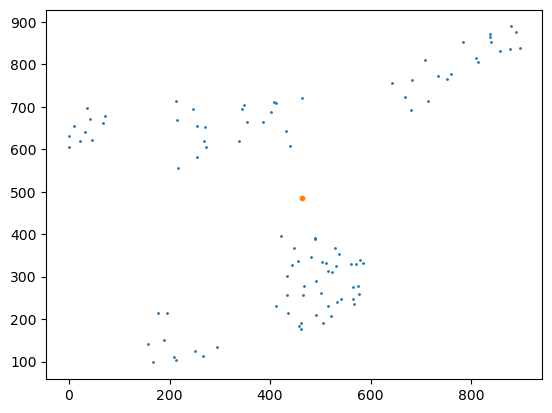

In [6]:
task_1_1 = cvxpy_model_builder(df_1)
summary(task_1_1, df_1);

### Case 1.2

Optimal
Optimal objective function value =  40885.33151292999
Optimal location = (464.05037, 394.69675)


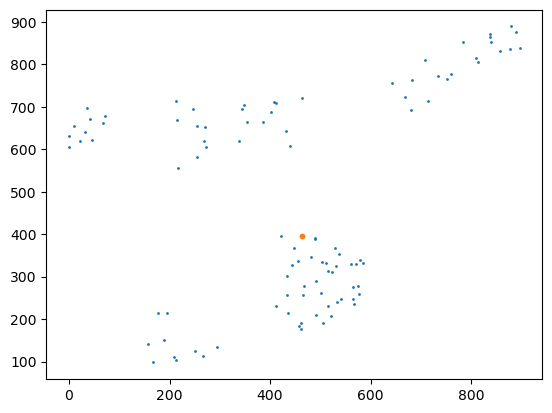

In [7]:
task_1_2 = pulp_model_builder_lecture(df_1)
summary(task_1_2, df_1)

### Case 1.3

Optimal
Optimal objective function value =  40885.331497549996
Optimal location = (460.92121, 394.69675)


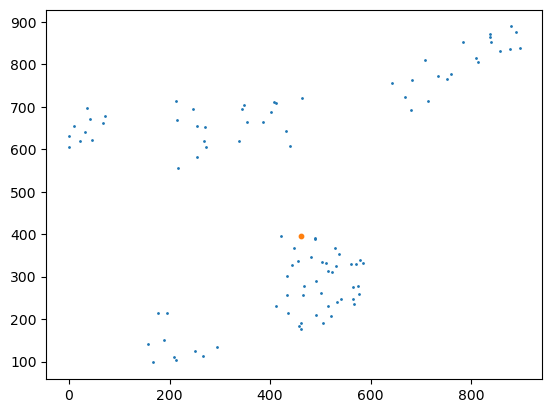

In [8]:
task_1_3 = pulp_model_builder(df_1)
summary(task_1_3, df_1)

### Case 2.1

In [9]:
df_2 = data_frame_converter("student_id_2018402021/HW1_2018402021_case_2.txt")

C:\Users\Casper\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
C:\Users\Casper\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Optimal objective function value =  518359.1995083657
Optimal location = (603.4161124330241, 332.65171829027565)


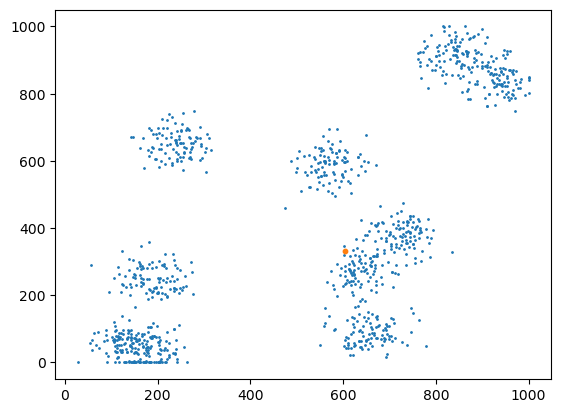

In [10]:
task_2_1 = cvxpy_model_builder(df_2)
summary(task_2_1, df_2)

### Case 2.2

Optimal
Optimal objective function value =  518359.19979545294
Optimal location = (603.42788, 332.8246)


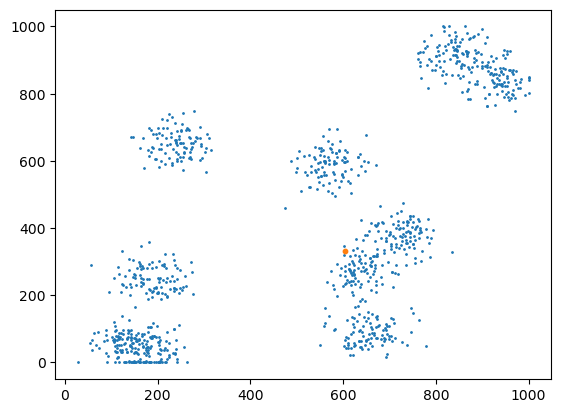

In [11]:
task_2_2 = pulp_model_builder_lecture(df_2)
summary(task_2_2, df_2)

### Case 2.3

Optimal
Optimal objective function value =  518359.19976514264
Optimal location = (603.42788, 332.47147)


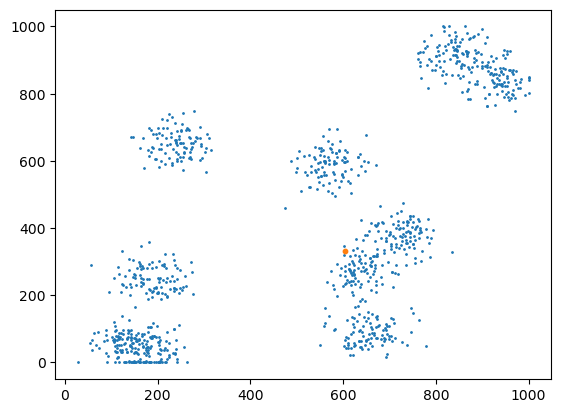

In [12]:
task_2_3 = pulp_model_builder(df_2)
summary(task_2_3, df_2)

### Case 3.1

In [13]:
df_3 = data_frame_converter("student_id_2018402021/HW1_2018402021_case_3.txt")

C:\Users\Casper\miniconda3\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
C:\Users\Casper\miniconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Optimal objective function value =  4147807.1905542724
Optimal location = (581.4656728496482, 450.77407804937707)


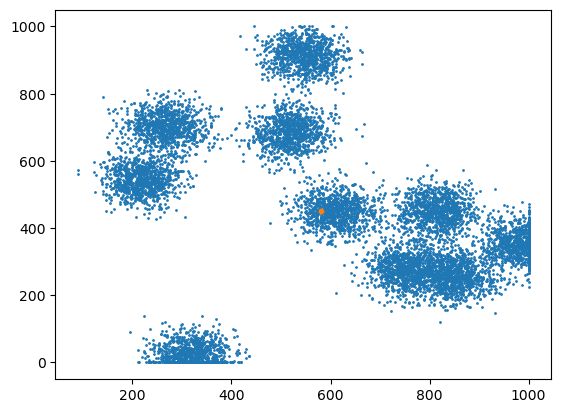

In [14]:
task_3_1 = cvxpy_model_builder(df_3)
summary(task_3_1, df_3)

### Case 3.2

Optimal
Optimal objective function value =  4147807.1895725755
Optimal location = (581.48824, 450.81976)


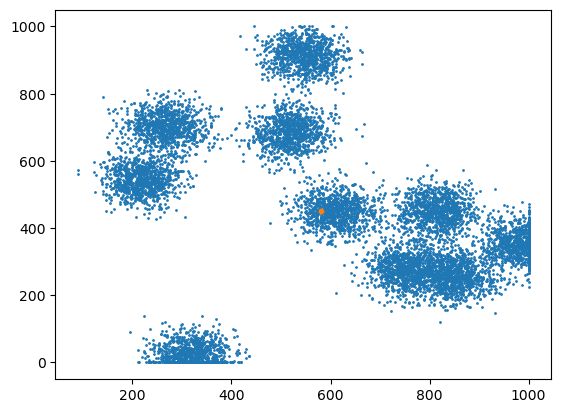

In [15]:
task_3_2 = pulp_model_builder_lecture(df_3)
summary(task_3_2, df_3)

### Case 3.3

Optimal
Optimal objective function value =  4147807.188133016
Optimal location = (581.44277, 450.74774)


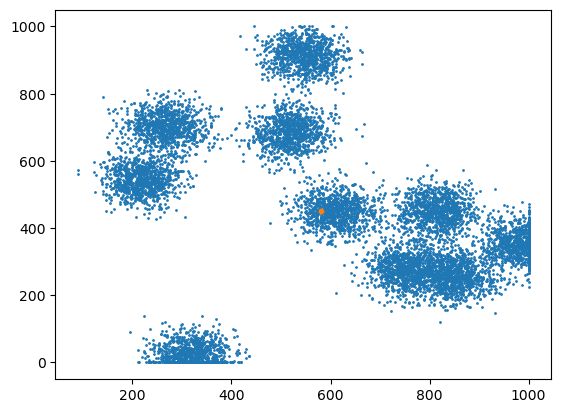

In [16]:
task_3_3 = pulp_model_builder(df_3)
summary(task_3_3, df_3)

## Task 4

In [17]:
def table_creater(column1, column2, column3, column4, column5, column6, column7):
    
    return pd.DataFrame({"z*" : column2,
                  "x*": column3,
                  "y*": column4,
                  "Runtime in secs": column5,
                  "Decision Variables": column6,
                  "Constraints" : column7}, index = column1)
        

### Case 1

In [18]:
column1 = ["Task 1", "Task 2", "Task 3"]
column2 = [task_1_1[1], task_1_2[1], task_1_3[1]]
column3 = [task_1_1[2], task_1_2[2], task_1_3[2]]
column4 = [task_1_1[3], task_1_2[3], task_1_3[3]]
column5 = [1.44, 0.383, 0.446]
column6 = [2, 202, 402]
column7 = [0, 400, 200]

table_creater(column1, column2, column3, column4, column5, column6, column7)

,z*,x*,y*,Runtime in secs,Decision Variables,Constraints
Task 1,40885.332,462.614,485.245,1.440,2,0
Task 2,40885.332,464.050,394.697,0.383,202,400
Task 3,40885.331,460.921,394.697,0.446,402,200


### Case 2

In [19]:
column1 = ["Task 1", "Task 2", "Task 3"]
column2 = [task_2_1[1], task_2_2[1], task_2_3[1]]
column3 = [task_2_1[2], task_2_2[2], task_2_3[2]]
column4 = [task_2_1[3], task_2_2[3], task_2_3[3]]
column5 = [3.121, 0.722, 0.461]
column6 = [2, 2002, 4002]
column7 = [0, 4000, 2000]

table_creater(column1, column2, column3, column4, column5, column6, column7)

,z*,x*,y*,Runtime in secs,Decision Variables,Constraints
Task 1,518359.200,603.416,332.652,3.121,2,0
Task 2,518359.200,603.428,332.825,0.722,2002,4000
Task 3,518359.200,603.428,332.471,0.461,4002,2000


### Case 3

In [20]:
column1 = ["Task 1", "Task 2", "Task 3"]
column2 = [task_3_1[1], task_3_2[1], task_3_3[1]]
column3 = [task_3_1[2], task_3_2[2], task_3_3[2]]
column4 = [task_3_1[3], task_3_2[3], task_3_3[3]]
column5 = [75.374, 20.658, 10.583]
column6 = [2, 20002, 40002]
colum7 = [0, 40000, 20000]

table_creater(column1, column2, column3, column4, column5, column6, column7)

,z*,x*,y*,Runtime in secs,Decision Variables,Constraints
Task 1,4147807.191,581.466,450.774,75.374,2,0
Task 2,4147807.190,581.488,450.820,20.658,20002,4000
Task 3,4147807.188,581.443,450.748,10.583,40002,2000


## Task 5

The numerical values for each case can be found above. Here, the value for each n value is formulated.


**Task 1**

We have only two DVs : x, y 

We have 100 xis and 100 yis.

We do not have any constraints.

**Task 2**

We have x, y, ai, bi as DVs. A total of 2 + 2 * n

x-xi <= ai

x-xi >= -ai

y-yi <= bi

y-yi >= -bi 

We have 4 constraints for each location, which means a total of 4 * n.

**Task 3**

x - xi = ti - ti'

y - yi = hi - hi'

For each location , we have 1 ti, 1 ti', 1 hi, 1 hi' as DVs.

We have 2 + 4 * n many DVs :  x, y, ti, ti', hi, hi'

We have 2 constraints for each location, thus 2 * n many constraints.


**Analysis**

Based on the run time, it can be said that, in general, the task 2 takes more time than task 3. 

Task 1 always takes significantly more time than the other cases.

Naturally enough, the runtime increased as the number of customers (n) increased. 

In [21]:
optimal_for_tasks = [task_1_1[1], task_1_2[1], task_1_3[1],
                     task_2_1[1], task_2_2[1], task_2_3[1],
                     task_3_1[1], task_3_2[1], task_3_3[1]]

for i in optimal_for_tasks:
    print(i)

40885.33153373339
40885.33151292999
40885.331497549996
518359.1995083657
518359.19979545294
518359.19976514264
4147807.1905542724
4147807.1895725755
4147807.188133016


### Task 6

The optimal locations and the customers are alraedy plotted for each case. Down below is for comparison.

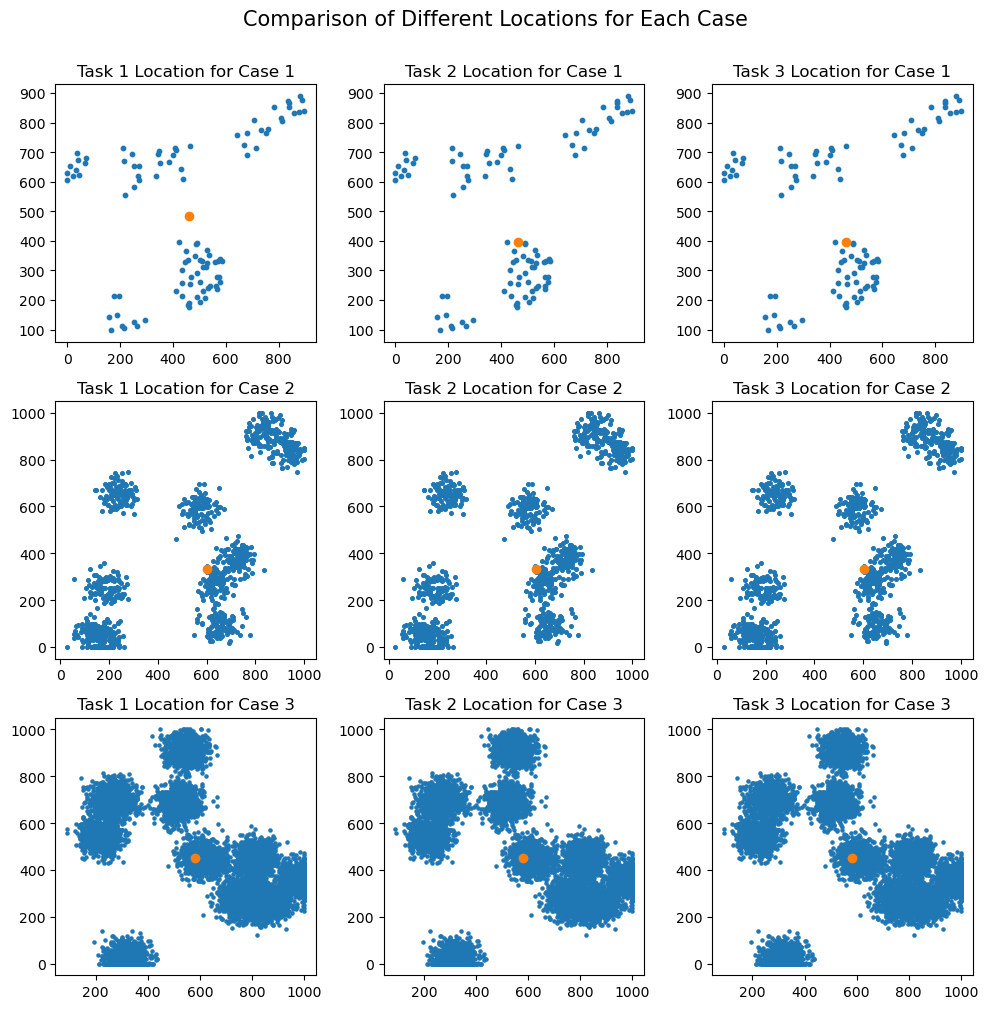

In [22]:
optimal_locations = [[task_1_1[2], task_1_1[3]], 
                     [task_1_2[2], task_1_2[3]],
                     [task_1_3[2], task_1_3[3]],
                     [task_2_1[2], task_2_1[3]],
                     [task_2_2[2], task_2_2[3]],
                     [task_2_3[2], task_2_3[3]],
                     [task_3_1[2], task_3_1[3]],
                     [task_3_2[2], task_3_2[3]],
                     [task_3_1[2], task_3_3[3]]]

fig, ax = plt.subplots(nrows=3,
                       ncols=3,
                       figsize=(10, 10))

ax[0, 0].scatter(x=df_1.to_numpy() [:,0], y=df_1.to_numpy()[:,1], s=10)
ax[0, 0].set_title('Task 1 Location for Case 1')
ax[0, 1].scatter(x=df_1.to_numpy() [:,0], y=df_1.to_numpy()[:,1], s=10)
ax[0, 1].set_title('Task 2 Location for Case 1')
ax[0, 2].scatter(x=df_1.to_numpy() [:,0], y=df_1.to_numpy()[:,1], s=10)
ax[0, 2].set_title('Task 3 Location for Case 1')
ax[0, 0].scatter(x=optimal_locations[0][0], y=optimal_locations[0][1])
ax[0, 1].scatter(x=optimal_locations[1][0], y=optimal_locations[1][1])
ax[0, 2].scatter(x=optimal_locations[2][0], y=optimal_locations[2][1])

ax[1, 0].scatter(x=df_2.to_numpy() [:,0], y=df_2.to_numpy()[:,1], s=7)
ax[1, 0].set_title('Task 1 Location for Case 2')
ax[1, 1].scatter(x=df_2.to_numpy() [:,0], y=df_2.to_numpy()[:,1], s=7)
ax[1, 1].set_title('Task 2 Location for Case 2')
ax[1, 2].scatter(x=df_2.to_numpy() [:,0], y=df_2.to_numpy()[:,1], s=7)
ax[1, 2].set_title('Task 3 Location for Case 2')
ax[1, 0].scatter(x=optimal_locations[3][0], y=optimal_locations[3][1])
ax[1, 1].scatter(x=optimal_locations[4][0], y=optimal_locations[4][1])
ax[1, 2].scatter(x=optimal_locations[5][0], y=optimal_locations[5][1])


ax[2, 0].scatter(x=df_3.to_numpy() [:,0], y=df_3.to_numpy()[:,1], s=5)
ax[2, 0].set_title('Task 1 Location for Case 3')
ax[2, 1].scatter(x=df_3.to_numpy() [:,0], y=df_3.to_numpy()[:,1], s=5)
ax[2, 1].set_title('Task 2 Location for Case 3')
ax[2, 2].scatter(x=df_3.to_numpy() [:,0], y=df_3.to_numpy()[:,1], s=5)
ax[2, 2].set_title('Task 3 Location for Case 3')
ax[2, 0].scatter(x=optimal_locations[6][0], y=optimal_locations[6][1])
ax[2, 1].scatter(x=optimal_locations[7][0], y=optimal_locations[7][1])
ax[2, 2].scatter(x=optimal_locations[8][0], y=optimal_locations[8][1])

plt.suptitle('Comparison of Different Locations for Each Case', fontsize=15, y=1.005)
plt.tight_layout()